# First Microtask of Project Reporting CHAOSS Metrics

## Under the Guidance of [CHAOSS](https://chaoss.community/ "chaoss") (Community Health Analytics Open Source Software)

Microtasks are part of an exercise to identify potential candidates for Gsoc 2k'18 under CHAOSS org

#### Task: Produce a listing of the number of new committers per month, and the number of commits for each of them, as a table and as a CSV file. Use the GrimoireLab enriched index for git.

**Step1**: Import all the necessary modules and libraries

In [104]:
from datetime import datetime, timedelta
from elasticsearch import Elasticsearch
from dateutil.relativedelta import relativedelta
from calendar import monthrange, month_name
from collections import defaultdict, OrderedDict
from pprint import pprint

import subprocess
import elasticsearch_dsl
import calendar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import six
%matplotlib inline

**Step2**: Define necessary parameters

In [4]:
# Elasticsearch URL i.e. the url at which elasticsearch instance is running.
ES_URL = "http://localhost:9200"  #In my case it is running at localhost

# Define an Elasticsearch object
es = Elasticsearch(ES_URL)

# URL of the repository to be analysed
repository_url = "https://github.com/Cloud-CV/EvalAI.git"

# Names of the indices by which the repository will be stored in elasticsearch instance
enriched_index_name = "cloud_git"     # enriched index
raw_index_name = "cloud_git_raw"      # raw index

**Step3**: Run p2o.py to automatically retrieve the data and index it

In [14]:
subprocess.run(['p2o.py', '--enrich', '--index', raw_index_name,
      '--index-enrich', enriched_index_name, '-e', ES_URL,
      '--no_inc', '--debug', 'git', repository_url])

CompletedProcess(args=['p2o.py', '--enrich', '--index', 'cloud_git_raw', '--index-enrich', 'cloud_git', '-e', 'http://localhost:9200', '--no_inc', '--debug', 'git', 'https://github.com/Cloud-CV/EvalAI.git'], returncode=0)

Let us check the total number of hits

In [5]:
query_res = es.search(index=enriched_index_name, body={"query":{"match_all":{}}})
total = query_res["hits"]["total"]
total

910

**Step4**: Get all commit records of the repository

In [7]:
def commit_records(index=None):
    "Queries the elasticsearch instance and returns all the documents in the index."
    
    search_result = es.search(index=index, body={"query":{"match_all":{}}})
    total = search_result["hits"]["total"]
    query = {
                "size":total, 
                "query":
                        {
                            "match_all":{}
                        }
            }
    query_result = es.search(index=index, body=query)
    results = [query_result["hits"]["hits"][i]["_source"] for i in range(query_result["hits"]["total"])]
    return results

In [8]:
results = commit_records(enriched_index_name) # Get all the documents

**Step5**: Build custom functions to analyze the repository

In [11]:
# Build a DSL Search object on the 'commits' index, 'summary' document type
request = elasticsearch_dsl.Search(using=es, index='cloud_git')

In [12]:
# Scan the actual document using elasticsearch_dsl object
response = request.scan()

In [13]:
# Let us check the total commits
total = request.count()
print("Count of total number of commits in index: ", total)  #Notice it matches the above hits

Count of total number of commits in index:  910


In [76]:
def date_parser(date, custom_format=None):
    """Returns a datetime.datetime object from a string. 
    custom_format for the date can be given as input"""
    
    if custom_format:
        return datetime.strptime(date, custom_format)
    
    return datetime.strptime(date, "%Y-%m-%dT%H:%M:%S")

In [16]:
def get_end_date_of_month(date):
    "Given a date, return the end date of the month"
    
    return date + relativedelta(days = +(monthrange(date.year, date.month)[1] - date.day))

In [17]:
def get_start_date_of_month(date):
    "Given a date, return the start date of the month"
    
    return date - relativedelta(days = +date.day-1)

In [18]:
def get_bucket_name(date):
    "Given a date return the a string in the form of Month-YYYY"
    
    return month_name[date.month] + "-" + str(date.year)

In [79]:
def get_extreme_commits_dates(commit_list):
    "Given a list of commits, return the dates of the first and the last commits"
    
    first_commit_date = min(date_parser(item['commit_date']) for item in commit_list)
    last_commit_date = max(date_parser(item['commit_date']) for item in commit_list)
    return first_commit_date, last_commit_date

In [20]:
def make_buckets(first_date, last_date):
    """Given the project start date and the last commit date, return 
    containers for months in between those dates. Each container is a month 
    containing details about all the commits and committers for that month."""
    
    buckets = OrderedDict()
    
    month_start_date = get_start_date_of_month(first_date)
    month_end_date = get_end_date_of_month(first_date)
    bucket_name = get_bucket_name(first_date)
    
    while month_end_date <= last_date:
        commit = {}
        commit['new_committers'] = defaultdict(int)
        commit['old_committers'] = defaultdict(int)
        commit['commits'] = []
        buckets[bucket_name] = commit
        
        month_start_date = month_end_date + relativedelta(days=+1)
        month_end_date = get_end_date_of_month(month_start_date)
        bucket_name = get_bucket_name(month_start_date)
    
    commit = {}
    commit['new_committers'] = defaultdict(int)
    commit['old_committers'] = defaultdict(int)
    commit['commits'] = []
    buckets[bucket_name] = commit
    
    return buckets

In [85]:
def Analyze_repository(commit_list):
    """Given a list of commit documents return 
    the number of new and old committers per month"""
    
    first_date, last_date = get_extreme_commits_dates(commit_list)
    
    months = make_buckets(first_date, last_date)
    
    for commit in commit_list:
        month = get_bucket_name(date_parser(commit['commit_date']))
        months[month]["commits"].append(commit)
        
    all_committers = []
    
    for name, month in months.items():
        for commit in month['commits']:
            committer = commit['author_name']
            if committer in all_committers:
                month['old_committers'][committer] += 1
            else:
                month['new_committers'][committer] += 1
        all_committers = list(set(all_committers + list(month['old_committers'].keys()) + 
                                  list(month['new_committers'].keys())))
        del month['commits']
                
    return months

In [86]:
Output = Analyze_repository(results)

**Result of Analysis**

In [23]:
format_template = '{:<25}{}'  # For pretty printing

print(format_template.format('Month', 'No. of new committers'))

for month_name, month in Output.items():
    if len(month["new_committers"]) != 0:
        print(format_template.format(month_name, len(month["new_committers"])))

Month                    No. of new committers
October-2016             2
November-2016            9
December-2016            2
January-2017             6
February-2017            3
March-2017               8
April-2017               2
May-2017                 2
August-2017              3
September-2017           5
October-2017             8
November-2017            5
December-2017            7
January-2018             7
February-2018            1
March-2018               3


**Step6**: Produce pandas Dataframes for making further analysis easier

In [24]:
def data_from_dict(commit_dict):
    data = []
    for month_name, month in commit_dict.items():
        item_list = []
        for key, val in month['new_committers'].items():
            item = {}
            item['month'] = month_name
            item["Author of commit"] = key
            item['Number of commits'] = val
            item_list.append(item)
        data = data + item_list
    
    return pd.DataFrame(data)

In [25]:
final_data = data_from_dict(Output)

In [26]:
final_data  # Dataframe produced

,Author of commit,Number of commits,month
0,Deshraj,11,October-2016
1,Deshraj Yadav,3,October-2016
2,Harsh Agrawal,12,November-2016
3,Taranjeet Singh,46,November-2016
4,Akash Jain,13,November-2016
5,rishabhjain,4,November-2016
6,arun jain,3,November-2016
7,Gautham Santhosh,1,November-2016
8,The Gitter Badger,1,November-2016
9,Anwesh Nayak,3,November-2016


In [27]:
#Group commits according to the month
no_of_new_commiters_per_month = final_data.groupby('month').count().drop('Number of commits', axis=1)

In [28]:
no_of_new_commiters_per_month.rename(columns = {'Author of commit': 'Number of new commiters'},inplace =True)

**Required Result: Table of new commiters per month""

In [29]:
no_of_new_commiters_per_month

,Number of new commiters
month,
April-2017,2
August-2017,3
December-2016,2
December-2017,7
February-2017,3
February-2018,1
January-2017,6
January-2018,7
March-2017,8


**Step7**: Save the result to csv file

In [30]:
final_data.to_csv(enriched_index_name + ".csv", index=False)

In [31]:
no_of_new_commiters_per_month.to_csv(enriched_index_name + "new commiters per month" + ".csv", index=False)

#### PANDAS APPROACH

Now let us try to solve this directly using pandas without defining custom functions and see the power of pandas

In [32]:
repo_data = pd.DataFrame(results)   # Make a dataframe of documents

In [33]:
repo_data.head()  # Examine the dataframe

,Author,Committer,author_date,author_domain,author_name,commit_date,committer_domain,committer_name,files,github_repo,...,offset,origin,repo_name,tag,title,tz,url_id,utc_author,utc_commit,uuid
0,Deshraj <deshrajdry@gmail.com>,Deshraj <deshrajdry@gmail.com>,2016-10-20T23:58:12,gmail.com,Deshraj,2016-10-20T23:58:12,gmail.com,Deshraj,2,Cloud-CV/EvalAI,...,None,https://github.com/Cloud-CV/EvalAI.git,https://github.com/Cloud-CV/EvalAI.git,https://github.com/Cloud-CV/EvalAI.git,README and contribution guidelines updated,-4,Cloud-CV/EvalAI/commit/114d7336902e186238ae34e...,2016-10-21T03:58:12,2016-10-21T03:58:12,6fda5d606c80de7d2f05bbc06ce0d3868be4de00
1,Harsh Agrawal <h.agrawal092@gmail.com>,Harsh Agrawal <h.agrawal092@gmail.com>,2016-11-02T00:09:33,gmail.com,Harsh Agrawal,2016-11-02T00:09:33,gmail.com,Harsh Agrawal,4,Cloud-CV/EvalAI,...,None,https://github.com/Cloud-CV/EvalAI.git,https://github.com/Cloud-CV/EvalAI.git,https://github.com/Cloud-CV/EvalAI.git,Updating configurations for third-party integr...,-5,Cloud-CV/EvalAI/commit/cb6dd7d9cc09032eb5ca12e...,2016-11-02T05:09:33,2016-11-02T05:09:33,fe5b3f52c5e12d30e26883768ba6e1b3f01493f0
2,Harsh Agrawal <h.agrawal092@gmail.com>,Harsh Agrawal <h.agrawal092@gmail.com>,2016-11-02T00:16:49,gmail.com,Harsh Agrawal,2016-11-02T00:16:49,gmail.com,Harsh Agrawal,4,Cloud-CV/EvalAI,...,None,https://github.com/Cloud-CV/EvalAI.git,https://github.com/Cloud-CV/EvalAI.git,https://github.com/Cloud-CV/EvalAI.git,Adding some testing support,-5,Cloud-CV/EvalAI/commit/1fb6c1c9ea446d7589cfdc5...,2016-11-02T05:16:49,2016-11-02T05:16:49,6755e27cf048db3556eea1f54f3f775ec2ff5c71
3,Deshraj <deshrajdry@gmail.com>,Deshraj <deshrajdry@gmail.com>,2016-11-03T19:52:18,gmail.com,Deshraj,2016-11-03T19:52:18,gmail.com,Deshraj,1,Cloud-CV/EvalAI,...,None,https://github.com/Cloud-CV/EvalAI.git,https://github.com/Cloud-CV/EvalAI.git,https://github.com/Cloud-CV/EvalAI.git,typo fix,-4,Cloud-CV/EvalAI/commit/e4d5528b471f9b03e529ea6...,2016-11-03T23:52:18,2016-11-03T23:52:18,1f2f7494a8a080fbd5bc34958ee5928e3418fbb0
4,Deshraj <deshrajdry@gmail.com>,Deshraj <deshrajdry@gmail.com>,2016-11-04T06:46:43,gmail.com,Deshraj,2016-11-04T06:46:43,gmail.com,Deshraj,1,Cloud-CV/EvalAI,...,None,https://github.com/Cloud-CV/EvalAI.git,https://github.com/Cloud-CV/EvalAI.git,https://github.com/Cloud-CV/EvalAI.git,requirements updated for production environment,-4,Cloud-CV/EvalAI/commit/469929c52ad220ecb2d0d19...,2016-11-04T10:46:43,2016-11-04T10:46:43,7260c130fba325a46bc665958cf225bd631b8cd0


In [34]:
# Drop every column except commit date and committer name
repo_data.drop(repo_data.columns.difference(['commit_date','committer_name']), axis=1, inplace = True) 

In [35]:
repo_data.dtypes #we can see commit_date is of object type rather than datetime type

commit_date       object
committer_name    object
dtype: object

In [36]:
repo_data.commit_date = pd.to_datetime(repo_data.commit_date) # converting to datetime

In [37]:
repo_data.dtypes # converted

commit_date       datetime64[ns]
committer_name            object
dtype: object

In [38]:
repo_data.set_index('commit_date', inplace=True) 

In [39]:
group=repo_data.groupby(pd.TimeGrouper("M"))  # group committers data by month

In [40]:
list(group)[0]  # inspect the group

(Timestamp('2016-10-31 00:00:00', offset='M'),
                     committer_name
 commit_date                       
 2016-10-20 20:10:50         GitHub
 2016-10-20 20:51:45  Deshraj Yadav
 2016-10-20 20:52:29        Deshraj
 2016-10-20 22:25:05        Deshraj
 2016-10-20 22:25:41        Deshraj
 2016-10-20 22:28:35        Deshraj
 2016-10-20 22:40:28        Deshraj
 2016-10-20 23:03:52        Deshraj
 2016-10-20 23:58:12        Deshraj
 2016-10-21 06:46:36        Deshraj
 2016-10-21 07:19:51        Deshraj
 2016-10-21 07:37:35        Deshraj
 2016-10-21 08:40:31         GitHub
 2016-10-21 09:19:11        Deshraj)

In [41]:
group.committer_name.value_counts() # find unique committers in each month

commit_date  committer_name  
2016-10-31   Deshraj             11
             GitHub               2
             Deshraj Yadav        1
2016-11-30   Deshraj Yadav       74
             GitHub              29
             Deshraj             20
             Harsh Agrawal       17
2016-12-31   Deshraj Yadav       54
             GitHub              18
2017-01-31   Deshraj Yadav       86
             GitHub              60
             Akash Jain          16
             Taranjeet Singh      4
             Shiv Baran Singh     1
2017-02-28   Deshraj Yadav       28
             GitHub              23
             Akash Jain          16
             Shiv Baran Singh     5
2017-03-31   GitHub              23
             Akash Jain          18
             Deshraj Yadav       17
             Shiv Baran Singh     8
             Taranjeet Singh      6
             Deshraj              4
             akashjain993         3
2017-04-30   GitHub              47
             Deshraj Yadav       1

In [42]:
group.committer_name.nunique()  # Find all the unique commiters across months

commit_date
2016-10-31    3
2016-11-30    4
2016-12-31    2
2017-01-31    5
2017-02-28    4
2017-03-31    7
2017-04-30    3
2017-05-31    4
2017-06-30    3
2017-07-31    2
2017-08-31    3
2017-09-30    3
2017-10-31    5
2017-11-30    5
2017-12-31    3
2018-01-31    5
2018-02-28    5
2018-03-31    5
Freq: M, Name: committer_name, dtype: int64

In [99]:
# Make a dataframe for smooth further processing
committer_data=pd.DataFrame({'month':group.committer_name.nunique().index, 'new committers per month':group.committer_name.nunique().values})

In [100]:
# Get name of month
committer_data['month'] = committer_data['month'].apply(lambda x: get_bucket_name(x))

In [101]:
committer_data.head()

,month,new committers per month
0,October-2016,3
1,November-2016,4
2,December-2016,2
3,January-2017,5
4,February-2017,4


In [43]:
# group data according to committers name
commiters_group=repo_data.groupby('committer_name')

In [44]:
# get numbers of commit by each committer
commit_count=commiters_group.committer_name.count()

**Number of commits by each committer**

In [45]:
commit_count

committer_name
Akash Jain           65
DESHRAJ               6
Deshraj              42
Deshraj Yadav       434
GitHub              265
Harsh Agrawal        17
RishabhJain2018      17
Shiv Baran Singh     21
Taranjeet Singh      30
akashjain993          3
geekayush             2
rishabhjain           6
spyshiv               1
xamfy                 1
Name: committer_name, dtype: int64

In [46]:
commiters_group.committer_name.count().sum() # verify sum of all committers equals total commits

910

In [47]:
df=pd.DataFrame({'committer name':commit_count.index, 'commit count':commit_count.values})

**Vizualize Result**

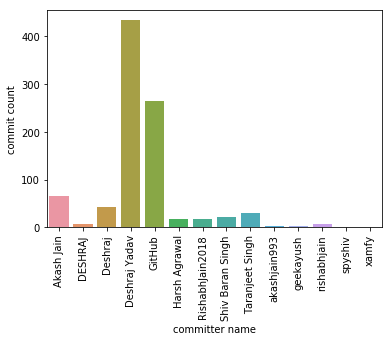

In [49]:
graph=sns.barplot(x="committer name", y="commit count", data=df)
for item in graph.get_xticklabels():
    item.set_rotation(90)

**Let us put some extra effort to make the table prettier**

In [67]:
def render_mpl_table(data, col_width=10.0, row_height=0.625, font_size=10,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    """Takes dataframe or series as input and convert it into a pretty table. 
       Height, color, font size can be adjusted"""
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return fig

***Produce table and save it***

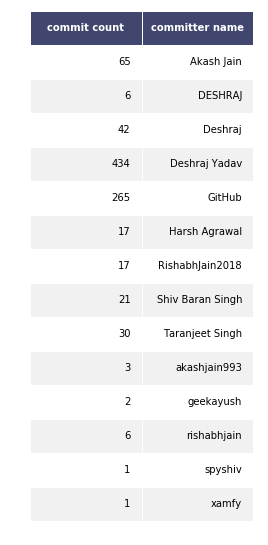

In [70]:
fig=render_mpl_table(df, header_columns=0, col_width=2.0)
fig.savefig('number of commits')

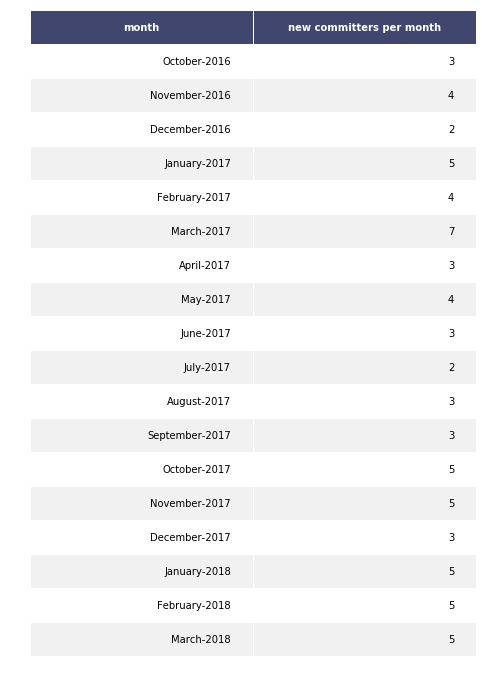

In [102]:
fig=render_mpl_table(committer_data, header_columns=0, col_width=4.0)
fig.savefig('new commiters per month')